In [ ]:
!pip install comet_ml pytorch-lightning torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.2/532.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.1/510.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import os

import matplotlib.pyplot as plt

import comet_ml
import torch.nn as nn
import pytorch_lightning as pl
import torch
import torch.nn.functional as F

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

In [ ]:
class Model(pl.LightningModule):
  def __init__(self, number_of_filters, learning_rate):
    super().__init__()

    self.save_hyperparameters()

    self.learning_rate = learning_rate

    self.val_correct_counter = 0
    self.val_total_counter = 0
    self.val_batch_counter = 0

    self.hidden0 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=number_of_filters, kernel_size=4),
        nn.LeakyReLU(0.2),
        # nn.BatchNorm2d(number_of_filters) 
    )

    self.hidden1 = nn.Sequential(
        nn.Conv2d(number_of_filters, number_of_filters * 4, kernel_size=4),
        nn.LeakyReLU(0.2),
        # nn.BatchNorm2d(number_of_filters * 4) 
    )

    self.hidden2 = nn.Sequential(
        nn.Conv2d(number_of_filters * 4, number_of_filters, kernel_size=4),
        nn.LeakyReLU(0.2),
        # nn.BatchNorm2d(number_of_filters) 
    )

    self.hidden3 = nn.Sequential(
        nn.Linear(5776, 1000),
        nn.LeakyReLU(0.2),
        # nn.BatchNorm1d(500)
    )

    self.hidden4 = nn.Sequential(
       nn.Linear(1000, 200),
       nn.LeakyReLU(0.2)
    )

    self.hidden5 = nn.Sequential(
        nn.Linear(200, 10)
    )

  def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)

        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)

        return x
  
  def training_step(self, batch, batch_idx):
      x, y = batch

      predicted = self.forward(x)
      loss = F.cross_entropy(predicted, y)

      self.logger.log_metrics({"train_loss": loss}, step=batch_idx)
      return loss
  
  def validation_step(self, batch, batch_idx):
      x, y = batch

      predicted = self.forward(x)
      loss = F.cross_entropy(predicted, y)

      # to calculate the test accuracy
      self.val_correct_counter += int((torch.argmax(predicted, 1).flatten() == y).sum())
      self.val_total_counter += y.size(0)

      self.logger.log_metrics({"val_loss": loss}, step=batch_idx)
      return loss

  def on_validation_epoch_end(self):
      # outputs is an array with what you returned in validation_step for each batch
      # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}]

      avg_acc = 100 * self.val_correct_counter / self.val_total_counter

      self.val_correct_counter = 0
      self.val_total_counter = 0

      self.logger.log_metrics({"val_acc": avg_acc}, step=self.val_batch_counter)

      self.val_batch_counter += 1
  
  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
class invertColor():
    """
    Is used to inverse the color of a dataset when this dataset is in range[0;1]
    """
    def __call__(self, img):
        return self.invert(img)

    def invert(self, img):
        return 1 - img

In [ ]:
class randomBlackToWhite():
    """
    Is used to transform some white pixels of the digit in black pixel
    """
    def __init__(self, prob):
      self.prob = prob

    def __call__(self, img):
        return self.randomBlackToWhite(img)

    def randomBlackToWhite(self, img, prob=0.9):
        return img * torch.distributions.bernoulli.Bernoulli(torch.tensor([self.prob])).sample(img.shape).squeeze(-1)

In [ ]:
compose = transforms.Compose([
          transforms.RandomCrop(28, padding=8, pad_if_needed=True, fill=1, padding_mode='edge'),
          transforms.ToTensor(),
          randomBlackToWhite(0.7),
          invertColor(),
          transforms.Normalize((0.5,), (0.5,))
      ])

In [ ]:
# Hyperparameters
hparam = {
    "learning_rate": 0.001,
    "number_of_filters": 16, # Needs to be 16 else switch linear Layer
    "batch_size": 128 * 6,
    "optimizer": "Adam"
}

# Parameters
experiment_name = "current_real_one_31_05"
checkpoint_folder = "./" + experiment_name + "_checkpoints/"
dataset_name = "MNIST_inv_color"
#dataset_name = "MNIST"
tags = ["cnn", "inverse_color", "Bernoulli", "randomly_padded"]
#tags = ["CNN", "MNIST_Inverted"]

In [ ]:
# Init Model
model = Model(hparam["number_of_filters"], hparam["learning_rate"])

In [ ]:
# Load Data
train_ds = MNIST(
    "data", train=True, download=True, transform=compose
)

train_loader = DataLoader(train_ds,  shuffle=True, batch_size=hparam["batch_size"])

eval_ds = MNIST(
    "data", train=False, download=True, transform=compose
)

eval_loader = DataLoader(train_ds, batch_size=hparam["batch_size"])

100%|██████████| 9912422/9912422 [00:00<00:00, 91650948.11it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108739402.00it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24790273.70it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22598492.01it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# init logger
comet_logger = CometLogger(
    api_key="hm3iPCrv0LDXFj8AHNO0uhBP4",
    rest_api_key="hm3iPCrv0LDXFj8AHNO0uhBP4",
    project_name="mnist-proseminar",
    experiment_name=experiment_name,
)

comet_logger.experiment.log_parameters(hparam)
comet_logger.experiment.add_tags(tags=tags)
comet_logger.experiment.log_dataset_info(name=dataset_name)

INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/luposx/mnist-proseminar/8d05194c4b1f49d78e109dbf57bdfbf8



In [ ]:
# Initalize the trainer
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_folder)
trainer = pl.Trainer(# fast_dev_run=True,
                      callbacks=checkpoint_callback,
                      accelerator="gpu",
                      max_epochs=3,
                      logger=comet_logger)
trainer.fit(model, train_loader, eval_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | hidden0 | Sequential | 272   
1 | hidden1 | Sequential | 16.4 K
2 | hidden2 | Sequential | 16.4 K
3 | hidden3 | Sequential | 5.8 M 
4 | hidden4 | Sequential | 200 K 
5 | hidden5 | Sequential | 2.0 K 
---------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
24.049    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/luposx/mnist-proseminar/8d05194c4b1f49d78e109dbf57bdfbf8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [21]        : (0.322592169046402, 2.209657907485962)
COMET INFO:     train_loss [237] : (0.28793516755104065, 2.401230573654175)
COMET INFO:     val_acc [4]      : (10.546875, 87.86666666666666)
COMET INFO:     val_loss [239]   : (0.22053073346614838, 2.3032913208007812)
COMET INFO:   Others:
COMET INFO:     Name         : current_real_one_31_05
COMET INFO:     dataset_info : MNIST_inv_color
COMET INFO:   Parameters:
COMET

In [ ]:
# log checkpoints
comet_logger.experiment.log_asset_folder(folder=checkpoint_folder)
comet_logger.experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/luposx/mnist-proseminar/8d05194c4b1f49d78e109dbf57bdfbf8

COMET WARNING: The default value for the log_file_name parameter will change from False to True in a future version. Explicitly pass log_file_name=True or log_file_name=False to disable this warning
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https

# Loading the Model and Classifying

In [ ]:
data = next(iter(train_ds))[0]

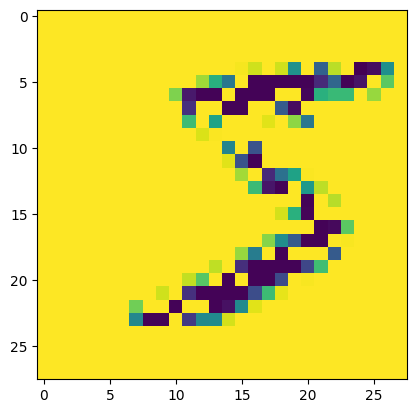

In [ ]:
plt.imshow(data.permute(1, 2, 0))

In [ ]:
print(data.size())
# We need one extra dimesnion to emulate batch size.
data = data.view(1, 1, 28, 28)
print(data.size())

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [ ]:
model = Model.load_from_checkpoint("current_real_one_31_05_checkpoints/epoch=2-step=237.ckpt")
model.eval()

with torch.no_grad():
   y_hat = model(data.cuda())

print("Results for Inference")
print("---------------------------")
print(" ")
print("Probabilities for Predicted-Labels: ", y_hat)
print(" ")
print("Predicted Label: ", y_hat.argmax())

Results for Inference
---------------------------
 
Probabilities for Predicted-Labels:  tensor([[ -2.6981,   1.6686,   3.3785,   8.8026, -10.4945,   9.5579,  -9.0084,
           1.5037,   0.7448,   0.0898]], device='cuda:0')
 
Predicted Label:  tensor(5, device='cuda:0')
